# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

The Goal of the project is to train a classifyer for images to predict traffic signs. It uses the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) as a basis, nicely already pickled into the right format by udacity.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

path = "/home/carnd/SDCND-Term1-TrafficSign/traffic-signs-data/"
#path="/Users/joergsimon/Dropbox/uni/SDCND/SDCND-Term1-TrafficSign/traffic-signs-data/"
training_file = path + "train.p"
validation_file= path + "valid.p"
testing_file = path + "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

Basic numbers about dataset size and dimensions are computed. An example image and visualization of a histogram over the distribution of the color space is shown

### Basic Info about Dataset:

In [2]:
import numpy as np
n_train = y_train.size
n_valid = y_valid.size
n_test = y_test.size
image_shape = X_train[0].shape[0:2]
all_y = np.concatenate((y_train,y_valid,y_test))
all_lbls = np.unique(all_y)
n_classes = all_lbls.size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Visualize random image and overal color histogram

In [3]:
def get_channel_histogram(channel_num):
    channel_histogram = np.zeros(256)
    for i in range(len(X_train)):
        img_data = X_train[i]
        for x in range(32):
            for y in range(32):
                val = img_data[x][y][channel_num]
                channel_histogram[val] = channel_histogram[val] + 1
    return channel_histogram

c1_hist = get_channel_histogram(0)
c2_hist = get_channel_histogram(1)
c3_hist = get_channel_histogram(2)

label:  28


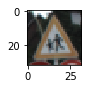

In [4]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print("label: ", y_train[index])

This is a histogram showing the color distribution over the whole test dataset. It is very equal distributed

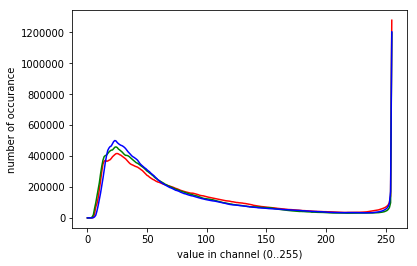

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(c1_hist, "r")
ax.plot(c2_hist, "g")
ax.plot(c3_hist, "b")
plt.xlabel('value in channel (0..255)')
plt.ylabel('number of occurance')
plt.show()

<Container object of 43 artists>

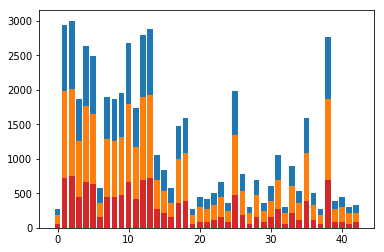

In [6]:
def get_classes_histogram(targets):
    classes_hist = np.zeros(43)
    for i in range(len(targets)):
        classes_hist[targets[i]] = classes_hist[targets[i]] + 1
    return classes_hist

classes_hist = get_classes_histogram(all_y)
x = range(43)
plt.bar(x, classes_hist)

classes_hist = get_classes_histogram(y_train)
x = range(43)
plt.bar(x, classes_hist)

classes_hist = get_classes_histogram(y_valid)
x = range(43)
plt.bar(x, classes_hist)

classes_hist = get_classes_histogram(y_test)
x = range(43)
plt.bar(x, classes_hist)

----

## Step 2: Design and Test a Model Architecture

Several models where tried, some of them are moved to the appendix. I started out with a LeNet-5 architecture as adviced in the course. A newer version also of [Sermanet and LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) were tried. That model improved the overal accuract already, but not above 90%. In the end a simple version of the first inception model with added Batch Normalization and Dropout moved the model to an accuracy of more then 93% (last try was 96% on validation set). So basically the resulting model is a variation of inception v2 with batchnorm and dropout, less deep and not using residual learning or decomposed filters like more modern inception models use. It would be nice to try these also, but for the submission this did not work in time.

The model is already huge, and usually less complex models overfit less. Dropout was added to deal with that.

### Pre-process the Data Set

Basically I only convert to greyscale. Centering image values and unit variance is not done, since that is done in the batch normalization layer within the network.

In [7]:
from sklearn.utils import shuffle
import tensorflow as tf
EPOCHS = 6
BATCH_SIZE = 128
X_train, y_train = shuffle(X_train, y_train)

In [8]:
# check if we are running on gpu's:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [9]:
import cv2
def convertToGrayscale(data):
    grey_data = np.ndarray((data.shape[0], 32, 32, 1), dtype=np.uint8)
    for i in range(data.shape[0]):
        img = data[i].squeeze()
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_image = np.expand_dims(gray_image, axis=2)
        grey_data[i] = gray_image
    return grey_data

g = convertToGrayscale(X_train)
X_train = g

g = convertToGrayscale(X_valid)
X_valid = g

g = convertToGrayscale(X_test)
X_test = g

### Visualize conversion
Just again visualize a simple random image and the overal histogram of all data after the greyscale conversion

17


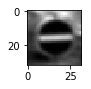

In [10]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

image = X_train[index]
image = image.reshape(image.shape[:-1])

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

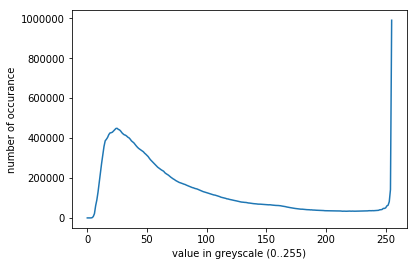

In [12]:
c1_hist_grey = get_channel_histogram(0)
fig, ax = plt.subplots(1,1)
ax.plot(c1_hist_grey)
plt.xlabel('value in greyscale (0..255)')
plt.ylabel('number of occurance')
plt.show()

### Model Architecture

### Helper funcions

Since I experimented with different architectures (beside the winning inception variant see the appendix for the other two) it is important to share code. The most basic repetitions of code are moved into this functions.

In [13]:
from tensorflow.contrib.layers import flatten
#from tensorflow.python import control_flow_ops

batch_size = BATCH_SIZE

def conv2d(input, weight_dim, num_biases, strides_dim=[1,1,1,1], padding = 'SAME'):
    # Filter (weights and bias)
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    # The shape of the filter bias is (output_depth,)
    # stride for each dimension (batch_size, height, width, depth)
    mu = 0
    sigma = 0.1
    F_W = tf.Variable(tf.truncated_normal(weight_dim, mu, sigma))
    F_b = tf.Variable(tf.truncated_normal(num_biases, mu, sigma))
    strides = strides_dim
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d
    # `tf.nn.conv2d` does not include the bias computation so we have to add it ourselves after.
    return tf.nn.bias_add(tf.nn.conv2d(input, F_W, strides, padding),F_b)

def activation(input):
    return tf.nn.relu(input)

def maxpool(input, ksize, strides, padding = 'VALID'):
    # ksize (filter size) for each dimension (batch_size, height, width, depth)
    # stride for each dimension (batch_size, height, width, depth)
    
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#max_pool
    return tf.nn.max_pool(input, ksize, strides, padding)

def connectedL(input, in_dim, out_dim):
    mu = 0
    sigma = 0.1
    weights = tf.Variable(tf.truncated_normal([in_dim, out_dim], mu, sigma))
    biases = tf.Variable(tf.truncated_normal([out_dim], mu, sigma))
    return tf.add(tf.matmul(input, weights),biases)

# taken from http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
def batch_norm(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def batch_norm_fullyc(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def batch_normf(x, phase_train=False, reuse=None, scope=None):
    return tf.contrib.layers.batch_norm(x, is_training=phase_train, reuse=reuse, scope=scope, updates_collections=None, decay=0.9, center=True, scale=True)

def debug_dim(thingwithshape, is_debug_on):
    if is_debug_on:
        if hasattr(thingwithshape, 'shape'):
            print(thingwithshape.shape)
        elif hasattr(thingwithshape, 'get_shape'):
            print (thingwithshape.get_shape())
        else:
            print("could not get shape:")
            print(thingwithshape)

#### Inception Model
The following model is inspired by the Model of GoogLeNet. Additionally BatchNorm and Dropout is added.

In [14]:
class Reductions:
    # table should be a list of duples of out dimensions in the form of:
    # [(1x1), (1x1, 3x3), (1x1, 5x5), (maxpool, 1x1)]
    def __init__(self, table):
        self.conv1x1 = table[0]
        self.conv3x3 = table[1]
        self.conv5x5 = table[2]
        self.maxpool = table[3]

def step(x, in_depth, out_depth, f, phase_train):
    c = conv2d(x, [f[0],f[1],in_depth,out_depth], [out_depth], padding = 'SAME')
    c = batch_normf(c, phase_train)
    c = activation(c)
    return c

def pool_s(x, pdim, sdim, padding):
    m = maxpool(x, pdim, sdim, padding=padding)
    m = batch_normf(m, phase_train)
    m = activation(m)
    return m

def pool_reduce(x, pdim):
    return pool_s(x, pdim, [1, 2, 2, 1], 'VALID')

def pool(x, pdim, padding):
    return pool_s(x, pdim, [1, 1, 1, 1], padding)

def inception_layer(x, input_depth, r, phase_train):
    debug_dimension = True
    if debug_dimension:
        print("-- inside inception --")
    #1x1:
    t1x1 = step(x, input_depth, r.conv1x1, (1,1), phase_train)
    debug_dim(t1x1, debug_dimension)
    #3x3:
    t3x3 = step(x, input_depth, r.conv3x3[0], (1,1), phase_train)
    debug_dim(t3x3, debug_dimension)
    t3x3 = step(t3x3, r.conv3x3[0], r.conv3x3[1], (3,3), phase_train)
    debug_dim(t3x3, debug_dimension)
    #5x5:
    t5x5 = step(x, input_depth, r.conv5x5[0], (1,1), phase_train)
    debug_dim(t5x5, debug_dimension)
    t5x5 = step(t5x5, r.conv5x5[0], r.conv5x5[1], (5,5), phase_train)
    debug_dim(t5x5, debug_dimension)
    #max-pool
    m = pool(x, [1, 3, 3, 1], 'SAME')
    debug_dim(m, debug_dimension)
    m = step(m, input_depth, r.maxpool, (1,1), phase_train)
    
    incept = tf.concat([t1x1, t3x3, t5x5, m], 3)
    if debug_dimension:
        print("-- end inception --")
    return incept   

def inception(x, keep_prob, phase_train):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    debug_dimension = True
    
    l = conv2d(x, [5,5,1,6], [6], padding='VALID')
    debug_dim(l, debug_dimension)
    l = activation(l)
    
    r = Reductions([(4), (3, 4), (3,4),(4)]) # 16
    l = inception_layer(l, 6, r, phase_train)
    
    r = Reductions([(8), (4, 8), (4,8),(8)]) # 32
    l = inception_layer(l, 16, r, phase_train)
    
    l = pool_reduce(l, [1, 2, 2, 1]) # 14x14
    debug_dim(l, debug_dimension)
    
    r = Reductions([(16), (8, 16), (8,16),(16)]) # 64
    l = inception_layer(l, 32, r, phase_train)
    
    r = Reductions([(32), (16, 32), (16,32),(32)]) # 128
    l = inception_layer(l, 64, r, phase_train)
    
    l = pool_reduce(l, [1, 2, 2, 1]) # 7x7
    debug_dim(l, debug_dimension)
    
    r = Reductions([(64), (32, 64), (32,64),(64)]) # 256
    l = inception_layer(l, 128, r, phase_train)
    
    #l = pool_reduce(l, [1, 2, 2, 1]) # 4x4
    #debug_dim(l, debug_dimension)
    
    r = Reductions([(128), (64, 128), (64,128),(128)]) # 512
    l = inception_layer(l, 256, r, phase_train)
    
    l = tf.nn.avg_pool(l, [1, 7, 7, 1], [1, 7, 7, 1], 'VALID')
    debug_dim(l, debug_dimension)
    l = flatten(l)
    debug_dim(l, debug_dimension)
    
    c = connectedL(l, 512, 120)
    # c = batch_norm_fullyc(c, 120, phase_train)
    c = batch_normf(c, phase_train)
    debug_dim(c, debug_dimension)
    c = activation(c)
    
    c = connectedL(c, 120, 84)
    # c = batch_norm_fullyc(c, 84, phase_train)
    c = batch_normf(c, phase_train)
    debug_dim(c, debug_dimension)
    c = activation(c)
    
    # Apply Dropout <- reason for this position, it is usually here
    c = tf.nn.dropout(c, keep_prob)
    
    c = connectedL(c, 84, 43)
    debug_dim(c, debug_dimension)
    
    logits = c
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

This is basically left as it is from the original course

In [25]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
phase_train = tf.placeholder(tf.bool, name='phase_train')
one_hot_y = tf.one_hot(y, 43)

In [16]:
rate = 0.001

logits = inception(x, keep_prob, phase_train)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 28, 28, 6)
-- inside inception --
(?, 28, 28, 4)
(?, 28, 28, 3)
(?, 28, 28, 4)
(?, 28, 28, 3)
(?, 28, 28, 4)
(?, 28, 28, 6)
-- end inception --
-- inside inception --
(?, 28, 28, 8)
(?, 28, 28, 4)
(?, 28, 28, 8)
(?, 28, 28, 4)
(?, 28, 28, 8)
(?, 28, 28, 16)
-- end inception --
(?, 14, 14, 32)
-- inside inception --
(?, 14, 14, 16)
(?, 14, 14, 8)
(?, 14, 14, 16)
(?, 14, 14, 8)
(?, 14, 14, 16)
(?, 14, 14, 32)
-- end inception --
-- inside inception --
(?, 14, 14, 32)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 14, 14, 64)
-- end inception --
(?, 7, 7, 128)
-- inside inception --
(?, 7, 7, 64)
(?, 7, 7, 32)
(?, 7, 7, 64)
(?, 7, 7, 32)
(?, 7, 7, 64)
(?, 7, 7, 128)
-- end inception --
-- inside inception --
(?, 7, 7, 128)
(?, 7, 7, 64)
(?, 7, 7, 128)
(?, 7, 7, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
-- end inception --
(?, 1, 1, 512)
(?, 512)
(?, 120)
(?, 84)
(?, 43)


In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, phase_train: False, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [70]:
def rand_indexes(data, num_idx):
    idx = list(range(0,len(data)))
    random.shuffle(idx)
    return idx[:num_idx]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    last_validation_accuracy = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, phase_train: True, keep_prob: 0.5})
        
        test_idx = rand_indexes(y_train, 4410) # same size as validation
        test_accuracy = evaluate(X_train[test_idx], y_train[test_idx])
        validation_accuracy = evaluate(X_valid, y_valid)
        delta = validation_accuracy - last_validation_accuracy
        last_validation_accuracy = validation_accuracy
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(test_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("delta = {:.3f}".format(delta))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Testset Accuracy = 0.710
Validation Accuracy = 0.624
delta = 0.624

EPOCH 2 ...
Testset Accuracy = 0.969
Validation Accuracy = 0.866
delta = 0.241

EPOCH 3 ...
Testset Accuracy = 0.993
Validation Accuracy = 0.926
delta = 0.060

EPOCH 4 ...
Testset Accuracy = 0.997
Validation Accuracy = 0.923
delta = -0.003

EPOCH 5 ...
Testset Accuracy = 0.999
Validation Accuracy = 0.944
delta = 0.021

EPOCH 6 ...
Testset Accuracy = 0.996
Validation Accuracy = 0.942
delta = -0.002

Model saved


---

## Step 3: Test a Model on New Images

Images were extracted from an article about to [many signs in germany](https://www.adfc-bw.de/bodenseekreis/radverkehr/lesenswert/schilderwald-am-bodensee/) and another image from a [driving school](http://www.3d-fahrschule.de/verkehrsschilder-in-deutschland-und-ihre-bedeutung/) (articles is in german).
From these images I extracted signs manually and changed them into greyscale and the correct dimensions.

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images
First show the original images from which I took the others

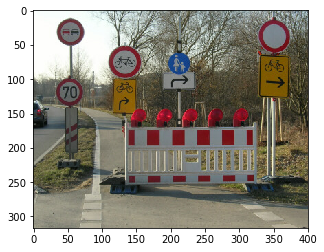

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img=mpimg.imread('images/article1.JPG')
plt.imshow(img)

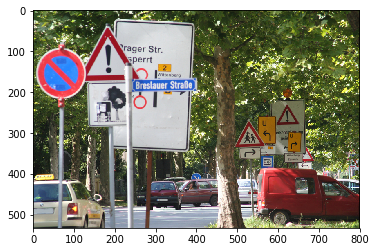

In [19]:
img=mpimg.imread('images/fahrschule.jpg')
plt.imshow(img)

From these two pictures I extracted the following 5 pictures of the signs and changed them to a 32x32 dimension. Later I converted them to greyscale.

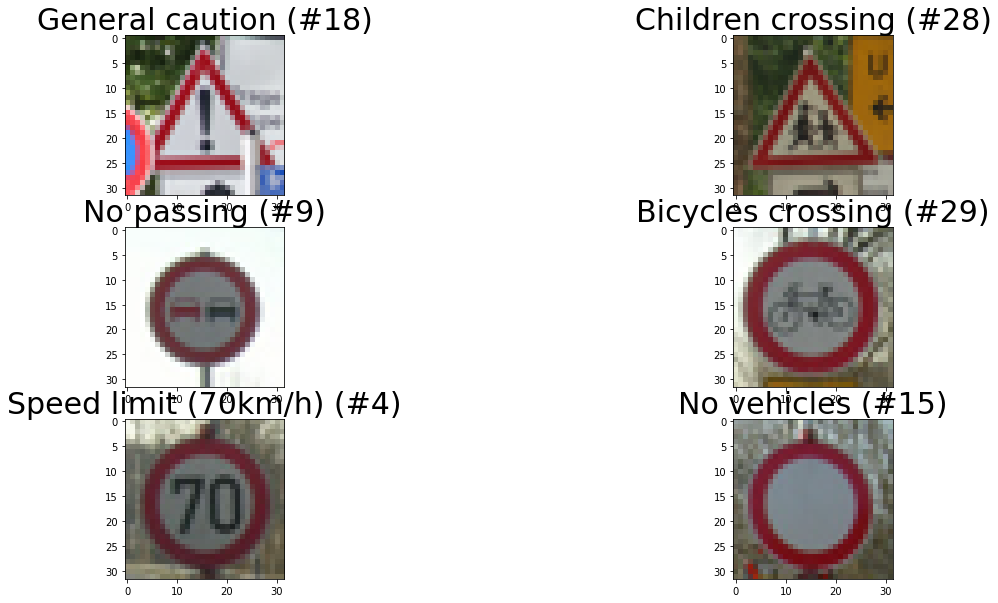

In [109]:
f, axarr = plt.subplots(3, 2, figsize=(20,10))

image = mpimg.imread('images/attention.png')
axarr[0, 0].imshow(image)
axarr[0, 0].set_title('General caution (#18)', fontsize=30)

image = mpimg.imread('images/attention_children.png')
axarr[0, 1].imshow(image)
axarr[0, 1].set_title('Children crossing (#28)', fontsize=30)

image = mpimg.imread('images/do_no_pass.png')
axarr[1, 0].imshow(image)
axarr[1, 0].set_title('No passing (#9)', fontsize=30) # Gandalf!

image = mpimg.imread('images/no_bicycles.png')
axarr[1, 1].imshow(image)
axarr[1, 1].set_title('Bicycles crossing (#29)', fontsize=30)

image = mpimg.imread('images/speed_limit.png')
axarr[2, 0].imshow(image)
axarr[2, 0].set_title('Speed limit (70km/h) (#4)', fontsize=30)

image = mpimg.imread('images/do_not_drive.png')
axarr[2, 1].imshow(image)
axarr[2, 1].set_title('No vehicles (#15)', fontsize=30)

I then confert the 5 pics to greyscale to feed to the classifier

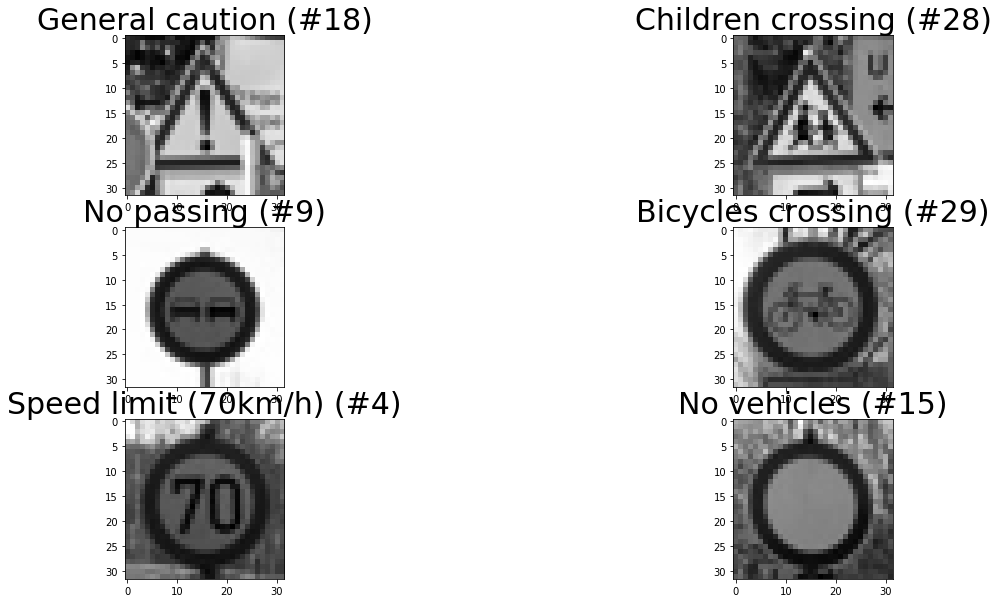

In [110]:
import cv2
f, axarr = plt.subplots(3, 2, figsize=(20,10))

image = mpimg.imread('images/attention.png')
image1 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image1 = cv2.medianBlur(image1,3)
axarr[0, 0].imshow(image1, cmap='gray')
axarr[0, 0].set_title('General caution (#18)', fontsize=30)

image = mpimg.imread('images/attention_children.png')
image2 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image2 = cv2.medianBlur(image2,3)
axarr[0, 1].imshow(image2, cmap='gray')
axarr[0, 1].set_title('Children crossing (#28)', fontsize=30)

image = mpimg.imread('images/do_no_pass.png')
image3 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image3 = cv2.medianBlur(image3,3)
axarr[1, 0].imshow(image3, cmap='gray')
axarr[1, 0].set_title('No passing (#9)', fontsize=30) # Gandalf!

image = mpimg.imread('images/no_bicycles.png')
image4 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image4 = cv2.medianBlur(image4,3)
axarr[1, 1].imshow(image4, cmap='gray')
axarr[1, 1].set_title('Bicycles crossing (#29)', fontsize=30)

image = mpimg.imread('images/speed_limit.png')
image5 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image5 = cv2.medianBlur(image5,3)
axarr[2, 0].imshow(image5, cmap='gray')
axarr[2, 0].set_title('Speed limit (70km/h) (#4)', fontsize=30)

image = mpimg.imread('images/do_not_drive.png')
image6 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image6 = cv2.medianBlur(image6,3)
axarr[2, 1].imshow(image6, cmap='gray')
axarr[2, 1].set_title('No vehicles (#15)', fontsize=30)

### Predict the Sign Type for Each Image

prepare the data for prediction and k5

In [79]:
# added a little later out of curiosity why nothing works
# in the end it was the format of the image (floating point 0..1 instad of 0..255 which ruined the classification)
image = mpimg.imread('images/120kmh.png')
image7 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

x_data = np.uint8(np.zeros((7,32,32,1)))
images = [image1, image2, image3, image4, image5, image6, image7]
for i in range(len(images)):
    img = images[i]
    img = cv2.convertScaleAbs(img*256)
    img = np.expand_dims(img, axis=2)
    x_data[i] = img

Predict the classes of the (in the end 7) images

In [80]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    pred = sess.run(tf.argmax(logits, 1), feed_dict={x: x_data, keep_prob: 1.0, phase_train: False})
    print(pred)

[18 11  9  2  4 15  0]


### Analyze Performance

In [111]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
desired_result = [18, 28, 9, 29, 4, 15, 8]
equal = pred[pred == desired_result]
accuracy = len(equal)/len(desired_result)
print("new image accuracy = {:.3f}".format(accuracy))

new image accuracy = 0.571


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [87]:
import pandas as pd
df = pd.read_csv('signnames.csv')

In [89]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    top5 = sess.run(tf.nn.softmax(logits), feed_dict={x: x_data, keep_prob: 1.0, phase_train: False})
    top5 = tf.nn.top_k(top5, 5)
    top5 = sess.run(top5)

In [115]:
def print_header(desired_name, desired_class, is_table=True):
    if is_table:
        print('desired sign: ', desired_name, desired_class)
        print('')
        print('| Probability         	|     Prediction	     						|')
        print('|:---------------------:|:---------------------------------------------:| ')
    else:
        print('desired sign: ', desired_name, desired_class)

def print_row(name, value, is_table=True):
    if is_table:
        template = '| {:.3f}    				| {} 					|'
        print(template.format(value, name))
    else:
        print('   -> ', name, '({:.3f})'.format(value))

res5 = zip(range(len(top5.values)), top5.values, top5.indices)
desired_in_top5 = 0
for i, val, idx in res5:
    desired_class = desired_result[i]
    desired_name = df[df['ClassId'] == desired_class]['SignName'].to_string()
    print_header(desired_name, desired_class, is_table=False)
    pred_top5 = zip(range(5), val, idx)
    for i,v,ind in pred_top5:
        if ind == desired_class:
            desired_in_top5 +=1
        name = df[df['ClassId'] == ind]['SignName'].to_string()
        print_row(name, v, is_table=False)
    print("")

accuracy = desired_in_top5/len(desired_result)
print("new image top 5 accuracy = {:.3f}".format(accuracy))

desired sign:  18    General caution 18
   ->  18    General caution (0.998)
   ->  11    Right-of-way at the next intersection (0.002)
   ->  27    Pedestrians (0.000)
   ->  23    Slippery road (0.000)
   ->  2    Speed limit (50km/h) (0.000)

desired sign:  28    Children crossing 28
   ->  11    Right-of-way at the next intersection (0.894)
   ->  29    Bicycles crossing (0.065)
   ->  21    Double curve (0.027)
   ->  24    Road narrows on the right (0.004)
   ->  28    Children crossing (0.003)

desired sign:  9    No passing 9
   ->  9    No passing (1.000)
   ->  16    Vehicles over 3.5 metric tons prohibited (0.000)
   ->  1    Speed limit (30km/h) (0.000)
   ->  10    No passing for vehicles over 3.5 metric tons (0.000)
   ->  19    Dangerous curve to the left (0.000)

desired sign:  29    Bicycles crossing 29
   ->  2    Speed limit (50km/h) (0.446)
   ->  9    No passing (0.239)
   ->  1    Speed limit (30km/h) (0.164)
   ->  3    Speed limit (60km/h) (0.041)
   ->  5    Sp

### Find final test set accuracy

In [116]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    testset_accuracy = evaluate(X_test, y_test)
    print('final accuracy on test set: {:.3f}'.format(testset_accuracy))


final accuracy on test set: 0.937


### Project Writeup

Additionally to the notebook the [project writeup](https://github.com/joergsimon/SDCND-Term1-TrafficSign/blob/master/report.md) can be found in the repository.

---

## Appendix
I tried three other network architecutres and trained them. One is based on LeNet-5, the other on the reference paper, and the last was an adoption of the reference paper. Non of them did move the accuracy on the validation set above 93% 

#### Le Net Model
As a starting point for the project in the videos the Le Net Model was suggested. Only small variations of the the Le Net Model needed to be done like changing the input and output dimension size. This is the version with the minimal amount of variations.

In [30]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # print debug dimensions
    debug_dimension = False
    
    # Layer 1: 
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    c1 = conv2d(x, [5,5,1,6], [6])
    debug_dim(c1, debug_dimension)
    # Activation.
    a1 = activation(c1)
    debug_dim(a1, debug_dimension)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    p1 = maxpool(a1, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p1, debug_dimension)
    # Layer 2: 
    # Convolutional. Output = 10x10x16.
    c2 = conv2d(p1, [5,5,6,16], [16])
    debug_dim(c2, debug_dimension)
    # Activation.
    a2 = activation(c2)
    debug_dim(a2, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2 = maxpool(a2, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p2, debug_dimension)
    # Flatten. Input = 5x5x16. Output = 400.
    f = flatten(p2)
    debug_dim(f, debug_dimension)
    # Layer 3: 
    # Fully Connected. Input = 400. Output = 120.
    c3 = connectedL(f, 400, 120)
    debug_dim(c3, debug_dimension)
    # Activation.
    a3 = activation(c3)
    debug_dim(a3, debug_dimension)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    c4 = connectedL(a3, 120, 84)
    debug_dim(c4, debug_dimension)
    # Activation.
    a4 = activation(c4)
    debug_dim(a4, debug_dimension)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    c5 = connectedL(a4, 84, 43)
    debug_dim(c5, debug_dimension)
    logits = c5
    return logits

#### Sermanet & LeCun Model
this is the model described in "Traffic sign recognition with multi-scale Convolutional Networks" 2011. However, several parameters are not exactly specified in the paper, for example:
* the size of the convolution filter (only the depth is described). Here I first tried with the sizes we also have in LeNet.
* the type of pooling layer: that paper states it uses a spatial feature pooling layer, but does not descripe it in detail, I use max pooling instead as it is recommendet in http://cs231n.github.io/convolutional-networks/
* the non-linear transform layer: instead of a ReLU activation the paper states to use a own local normalization function. I might also have gotten that wrong. Again I use the std. ReLU as suggested in http://cs231n.github.io/convolutional-networks/

Beside the other rational of the coices it seems also that these Filters are used from both in the more recent OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks Model

In [31]:
def sermant_lecun(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # print debug dimensions
    debug_dimension = True
    
    # Layer 1: 
    # Convolutional. Input = 32x32x1. Output = 28x28x108.
    c1 = conv2d(x, [5,5,1,108], [108])
    debug_dim(c1, debug_dimension)
    # Activation.
    a1 = activation(c1)
    debug_dim(a1, debug_dimension)
    # Pooling. Input = 28x28x108. Output = 14x14x108.
    p1 = maxpool(a1, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p1, debug_dimension)
    
    # Layer 2: 
    # Convolutional. Input = 14x14x108. Output = 10x10x200.
    c2 = conv2d(p1, [5,5,108,200], [200])
    debug_dim(c2, debug_dimension)
    # Activation.
    a2 = activation(c2)
    debug_dim(a2, debug_dimension)
    # Pooling. Input = 10x10x200. Output = 5x5x200.
    p2 = maxpool(a2, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p2, debug_dimension)
    
    # Layer 3:
    # flatten Layer 1 & Layer 2 and concatenate, giving 21168 + 5000 = 26168
    f1 = flatten(p1)
    debug_dim(f1, debug_dimension)
    f2 = flatten(p2)
    debug_dim(f2, debug_dimension)
    f = tf.concat(1,(f1,f2))
    debug_dim(f, debug_dimension)
    # Fully Connected. Input = 26168. Output = 200.
    c3 = connectedL(f, 26168, 200)
    debug_dim(c3, debug_dimension)
    # Activation.
    a3 = activation(c3)
    debug_dim(a3, debug_dimension)
    
    # Layer 4:
    # Fully Connected. Input = 200. Output = 100.
    c4 = connectedL(a3, 200, 100)
    debug_dim(c4, debug_dimension)
    # Activation.
    a4 = activation(c4)
    debug_dim(a4, debug_dimension)
    
    # Layer 5: 
    # Fully Connected. Input = 100. Output = 43.
    c5 = connectedL(a4, 100, 43)
    debug_dim(c5, debug_dimension)
    logits = c5
    return logits
    

#### Sermanet LeCun Adoptions

The Semanet and LeCun Network the way I understood it did not work well. I guess there are many things open for interpretation. One way to look at the network is to see it as a LeNet network with the output of the first and second layer coupled together. Additionally more conv layers with iterative deeper features seem to work good. On the other hand when connecting all the intermediate layers we want the global features to be dominant, but usually you have most of the local features. Because of that each layer has two poolings, one for the next layer, one for the connection of all of them to have siutable sizes. This architecture is a trial of that.

In [32]:
def LeNet_l1andl2connected(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # print debug dimensions
    debug_dimension = True
    
    # Layer 1: 
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    c1 = conv2d(x, [5,5,1,6], [6])
    debug_dim(c1, debug_dimension)
    # Activation.
    a1 = activation(c1)
    debug_dim(a1, debug_dimension)
    
    # Pooling 1 will be used for the next step of convolutions
    # but since we combine the output of pooling 1 and pooling 2
    # we want to have a balanced number of features of lower and
    # higher level invariants. with directly feeding the response
    # of pooling 1 into the fully connected, we end up with giving lower
    # level features more weight. So we use a second pooling filter
    # to go over the data and use that
    
    # Pooling 1. Input = 28x28x6. Output = 14x14x6.
    p1 = maxpool(a1, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p1, debug_dimension)
    # Pooling 2. Input = 28x28x6. Output = 7x7x6.
    p1_l4 = maxpool(a1, [1, 5, 5, 1], [1, 5, 5, 1])
    debug_dim(p1_l4, debug_dimension)
    
    # Layer 2: 
    # Convolutional. Output = 10x10x16.
    c2 = conv2d(p1, [5,5,6,16], [16])
    debug_dim(c2, debug_dimension)
    # Activation.
    a2 = activation(c2)
    debug_dim(a2, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2 = maxpool(a2, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p2, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2_l4 = maxpool(a2, [1, 3, 3, 1], [1, 3, 3, 1])
    debug_dim(p2_l4, debug_dimension)
    
    # Layer 3: 
    # Convolutional. Output = 4x4x32.
    c_3 = conv2d(p2, [2,2,16,32], [32])
    debug_dim(c_3, debug_dimension)
    # Activation.
    a_3 = activation(c_3)
    debug_dim(a_3, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 2x2x32.
    p_3 = maxpool(a_3, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p_3, debug_dimension)
    
    # Layer 4: 
    # Flatten.
    f1 = flatten(p1_l4)
    debug_dim(f1, debug_dimension)
    f2 = flatten(p2_l4)
    debug_dim(f2, debug_dimension)
    f3 = flatten(p_3)
    debug_dim(f3, debug_dimension)
    f = tf.concat(1,(f1,f2,f3))
    # Fully Connected. Input = 422. Output = 120.
    c3 = connectedL(f, 422, 120)
    debug_dim(c3, debug_dimension)
    # Activation.
    a3 = activation(c3)
    debug_dim(a3, debug_dimension)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    c4 = connectedL(a3, 120, 84)
    debug_dim(c4, debug_dimension)
    # Activation.
    a4 = activation(c4)
    debug_dim(a4, debug_dimension)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    c5 = connectedL(a4, 84, 43)
    debug_dim(c5, debug_dimension)
    logits = c5
    return logits